In [1]:
import importlib
import sys
import pandas as pd
import numpy as np

sys.path.append("../")
import biobss


In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
os.getcwd()

'c:\\Users\\Cagatay\\Desktop\\Biobss Workspace\\Plot Branch\\biobss\\examples'

In [4]:
import neurokit2 as nk
sample_data = pd.read_pickle("../sample_data/EDA_Chest.pkl")
sample_data = sample_data.flatten()

In [5]:
decompose = biobss.pipeline.Bio_Process(process_method=biobss.edatools.eda_decompose,method="highpass")

clean=biobss.pipeline.Bio_Process(
    process_method=biobss.edatools.eda_clean,argmap={"sampling_rate":"sampling_rate"},method="neurokit")

normalize = biobss.pipeline.Bio_Process(
    process_method=biobss.preprocess.normalize_signal)
resample = biobss.pipeline.Bio_Process(
    process_method=biobss.preprocess.resample_signal_object,target_sample_rate=350)
signal_features = biobss.pipeline.Feature(name="signal_features", function=biobss.edatools.eda_signalfeatures.get_signal_features, input_signals={'EDA_Raw':'EDA_Raw', 'EDA_Tonic':'EDA_Tonic', 'EDA_Phasic':'EDA_Phasic'})
stat_features = biobss.pipeline.Feature(name="stat_features", function=biobss.edatools.get_stat_features, input_signals={'EDA_Raw':'EDA_Raw', 'EDA_Tonic':'EDA_Tonic', 'EDA_Phasic':'EDA_Phasic'})

In [6]:
pipeline = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=60,step_size=20)

In [7]:
channel=biobss.pipeline.Bio_Channel(signal=sample_data,name="EDA_Raw",sampling_rate=700)

In [8]:
channel

EDA_Raw (700Hz) ((5920.0,)s) (1 windows) ((4144000,)) ((4144000,)) (float64)[5.40046692 5.40885925 5.40161133 ... 7.26280212 7.26966858 7.2681427 ]

In [9]:
pipeline.set_input(sample_data,sampling_rate=700,name='EDA_Raw')

In [10]:
pipeline.input

Signal object with 1 channel(s)
EDA_Raw (700Hz) ((5920.0,)s) (1 windows) ((4144000,))

In [11]:
pipeline.preprocess_queue.add_process(clean)
pipeline.preprocess_queue.add_process(normalize)
pipeline.preprocess_queue.add_process(decompose)
pipeline.preprocess_queue.add_process(resample)


In [12]:
pipeline.add_feature_step(signal_features)
pipeline.add_feature_step(stat_features)


In [13]:
pipeline

Bio_Pipeline:
	Preprocessors: Process list:
	1: eda_clean
	2: normalize_signal
	3: eda_decompose
	4: resample_signal_object

	Processors: Process list:

	Postprocessors: Process list:

	Window Size(Seconds): 60
	Step Size: 20

In [14]:
pipeline.run_pipeline()

In [15]:
pipeline.input

Signal object with 3 channel(s)
EDA_Raw (350Hz) (60.0s) (294 windows) ((294, 21000))
EDA_Tonic (350Hz) (60.0s) (294 windows) ((294, 21000))
EDA_Phasic (350Hz) (60.0s) (294 windows) ((294, 21000))

In [20]:
pipeline.input['EDA_Raw'].channel[0]

array([-0.77021659, -1.50324037, -1.25842645, ..., -1.11875179,
       -1.11878738, -1.11885975])

IndexError: index 3 is out of bounds for axis 0 with size 3

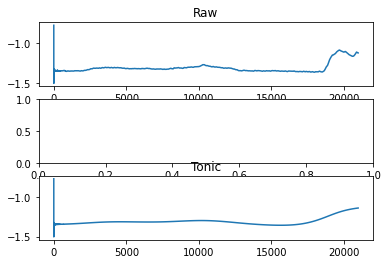

In [23]:
biobss.edatools.eda_plot({'Raw':pipeline.input['EDA_Raw'].channel[0],'Tonic':pipeline.input['EDA_Tonic'].channel[0],'Phasic':pipeline.input['EDA_Phasic'].channel[0]},sampling_rate=350)

In [16]:
pipeline.extract_features()

In [17]:
pipeline.features

,EDA_Raw_rms,EDA_Raw_acr_length,EDA_Raw_integral,EDA_Raw_average_power,EDA_Tonic_rms,EDA_Tonic_acr_length,EDA_Tonic_integral,EDA_Tonic_average_power,EDA_Phasic_rms,EDA_Phasic_acr_length,...,EDA_Tonic_skew,EDA_Tonic_momentum,EDA_Phasic_mean,EDA_Phasic_std,EDA_Phasic_max,EDA_Phasic_min,EDA_Phasic_range,EDA_Phasic_kurtosis,EDA_Phasic_skew,EDA_Phasic_momentum
0.0,1.307896,20999.302353,27434.243861,1.710591,1.308357,20999.302980,27457.360721,1.711798,0.026455,20999.000076,...,2.095446,0.002259,0.001101,0.026432,0.107763,-0.089481,0.197244,5.162175,0.612499,0.000699
20000.0,1.238578,20999.000103,25907.082826,1.534075,1.237605,20999.000013,25896.209117,1.531667,0.026826,20999.000084,...,0.336681,0.011001,-0.000518,0.026821,0.107763,-0.089481,0.197244,4.875817,0.747219,0.000719
40000.0,1.169487,20999.000145,24453.214018,1.367700,1.167398,20999.000010,24424.712270,1.362819,0.032283,20999.000127,...,-0.983479,0.010060,-0.001357,0.032254,0.107763,-0.089481,0.197244,2.081785,0.855737,0.001040
60000.0,1.129684,20999.000132,23684.947286,1.276185,1.127666,20999.000006,23652.997232,1.271631,0.022655,20999.000122,...,-1.316493,0.003004,-0.001521,0.022604,0.099171,-0.040446,0.139617,3.444132,1.518407,0.000511
80000.0,1.212992,20999.000124,25356.904618,1.471350,1.212625,20999.000006,25359.433891,1.470459,0.021986,20999.000113,...,-0.271838,0.012181,0.000120,0.021985,0.099171,-0.040446,0.139617,3.701695,1.442919,0.000483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780000.0,0.892047,20999.000041,18731.226166,0.795748,0.892398,20999.000001,18739.063803,0.796373,0.005386,20999.000040,...,-0.158085,0.000109,-0.000373,0.005373,0.013347,-0.013719,0.027066,-0.720037,0.025223,0.000029
5800000.0,0.887221,20999.000040,18630.495739,0.787161,0.886614,20999.000002,18618.155856,0.786084,0.005476,20999.000038,...,0.272679,0.000062,0.000588,0.005444,0.013068,-0.013719,0.026787,-0.603541,0.023752,0.000030
5820000.0,0.916729,20999.000088,19202.031070,0.840392,0.915463,20999.000007,19184.082240,0.838073,0.013858,20999.000080,...,1.742078,0.003540,0.000855,0.013831,0.059136,-0.043795,0.102932,2.533057,0.148651,0.000191
5840000.0,0.965596,20999.000166,20208.999048,0.932375,0.965569,20999.000013,20218.380497,0.932323,0.021105,20999.000149,...,0.113404,0.005377,-0.000449,0.021100,0.062023,-0.059352,0.121375,0.865320,0.090870,0.000445


In [18]:
pipeline.input

Signal object with 3 channel(s)
EDA_Raw (350Hz) (60.0s) (294 windows) ((294, 21000))
EDA_Tonic (350Hz) (60.0s) (294 windows) ((294, 21000))
EDA_Phasic (350Hz) (60.0s) (294 windows) ((294, 21000))

In [15]:
eda_data = biobss.pipeline.Bio_Channel(sample_data, sampling_rate=700, name="EDA_Raw",timestamp_resolution='s')

Text(0.5, 0.98, 'EDA_Raw')

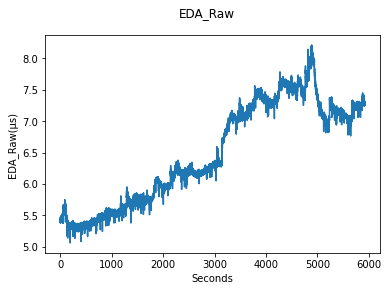

In [6]:
plt.plot(eda_data.timestamp,eda_data.channel)
plt.ylabel("EDA_Raw(\u03BCs)")
plt.xlabel("Seconds")
plt.suptitle("EDA_Raw")

In [8]:
eda_decomposed=decompose.process(eda_data)

Input is set with timestamp resolution of ms
Input is set with timestamp resolution of ms


Text(0.5, 0.98, 'EDA_Tonic')

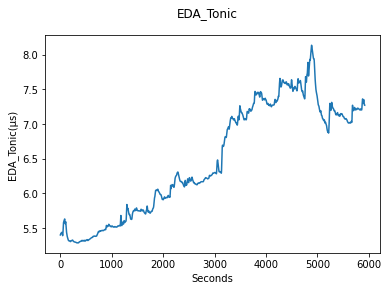

In [14]:
plt.plot(eda_decomposed['EDA_Tonic'].timestamp,eda_decomposed['EDA_Tonic'].channel)
plt.ylabel("EDA_Tonic(\u03BCs)")
plt.xlabel("Seconds")
plt.suptitle("EDA_Tonic")


Text(0.5, 0.98, 'EDA_Phasic')

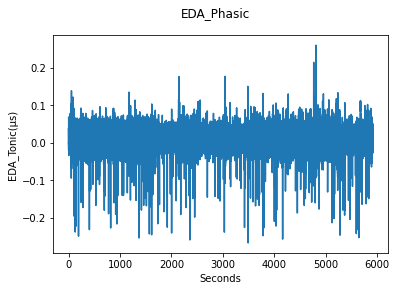

In [15]:
plt.plot(eda_decomposed['EDA_Phasic'].timestamp,eda_decomposed['EDA_Phasic'].channel)
plt.ylabel("EDA_Tonic(\u03BCs)")
plt.xlabel("Seconds")
plt.suptitle("EDA_Phasic")
